In [1]:
import numpy as np
import random
from math import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Stochastique Gradient Langevin Dynamics for logistic regression

In [7]:
def mini_batch(Num_sample,batch_size):
  '''
  Inputs:
    Num_sample: number of total samples
    batch_size: the length of the mini_batch
  ------------------------------------------------
  outputs:
    list_mini_batch: list containing mini_batches' lists
  '''
  L=list(np.arange(Num_sample))
  list_mini_batch=[]
  while len(L)>batch_size:  
    batch=list(np.random.choice(L, batch_size, replace=False))
    list_mini_batch.append(batch)
    res = [i for i in L if i not in batch]
    L=res
  if L!=[]:
    list_mini_batch.append(L)
  return(list_mini_batch)

def sigmoid(z):
  return(1/(1 + np.exp(-z)))

def prior_grad(theta):
  '''
  This function computes the gradient of the prior funtion at theta
  '''
  return(-1*np.sign(theta))

def lk_hood_grad(x,theta):
  '''
  This function computes the gradient of the likelihood of x for the parameter theta
  '''
  grad=sigmoid(-1*x[1]*np.inner(theta,x[0]))*x[1]*x[0]
  return(grad)

def step_update(theta,mini_batch,data):
    likelihood_grad=sum([lk_hood_grad(data[i],theta) for i in mini_batch])*(len(data)/len(mini_batch))
    new_step=prior_grad(theta) + likelihood_grad
    return(new_step)
    
def eps_t(t):
  ''' 
  this function computes the value of the rate epsilon at instant t
  '''
  return(a/((b+t)**(gamma)))

def Stoc_lang_grad(data,batch_size,len_feature,num_repet,num_run):
  '''
  This function applies the Stochastic Gradient Langevin Dynamics
  ----------------------------------------------------------------
  inputs:
   data:
   batch size: integer
   num_repet: number of sweeps through the whole data
   num_run: number of run 
   len_feature: the legth of the learned vector
  ----------------------------------------------------------------
  outputs: list of the learned vector during iterations

  '''
  Num_sample=len(data)
  theta_final_list=[]
  for run in tqdm(range(num_run)):
    list_mini_batch=mini_batch(Num_sample,batch_size)
    j=0
    theta_list=[np.random.rand(len_feature)]
    for i in range(1,num_repet* len(list_mini_batch)+1):
      theta= theta_list[-1] + (0.5*eps_t(i)*(step_update(theta_list[-1],list_mini_batch[j],data)+ np.random.normal(0,sqrt(eps_t(i)),size=len_feature)))
      if j< (len(list_mini_batch)-1):
        j+=1
      else:
        j=0
      theta_list.append(theta)
    theta_final_list.append(theta_list)
  return(np.sum(theta_final_list,axis=0)/num_run)


### Getting the a9a dataset and processing it


In [4]:
# Parser
def parser(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()
    x = np.zeros((len(lines), 124))
    y = np.ones(len(lines))
    i = 0
    for line in lines:
        data = line.strip().split()
        y[i] = int(data[0])
        data = data[1:]
        for dataFeat in data:
            feat = dataFeat.split(':')
            x[i, int(feat[0])] = 1.0
        i += 1
    return x, y

# Training: a9a/a9a / Test: a9a/a9a.t
datasetPath = []
datasetPath.append('a9a')
datasetPath.append('a9a.t')

# Parser dataset

xTrain, yTrain = parser(datasetPath[0])
xTest, yTest = parser(datasetPath[1])
train_data=[[np.array(xTrain[i]).astype(int),int(yTrain[i])] for i in range(len(xTrain))]
test_data=[[np.array(xTest[i]).astype(int),int(yTest[i])] for i in range(len(xTest))]

###  Learning

In [8]:
#parameter of the learning rate
a=0.05
b=10
gamma=0.55

#hyperparameters of learning
batch_size=3
num_run=22
num_repet=5


len_feature=124 # the length of the learned vector

#list of the learned vector during the learning
beta_list=Stoc_lang_grad(train_data,batch_size,len_feature,num_repet,num_run)

  0%|          | 0/22 [00:00<?, ?it/s]

C:\Users\benya\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


###  Evaluation

In [9]:
# Accuracy computing
def accuracy(xTest, yTest,beta):
  Y_algo=np.array([np.sign(2*sigmoid(np.sum(beta*i))-1) for i in xTest])
  Y_=np.zeros_like(yTest)
  Y_[Y_algo.astype(int)==yTest.astype(int)]=1
  return(np.sum(Y_)/len(Y_))

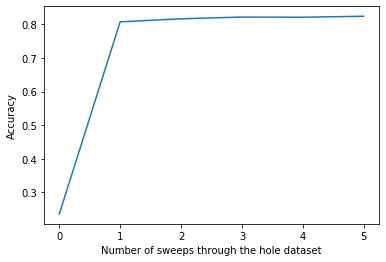

In [10]:
# testing on the Test dataset
Sweep_duration=len(mini_batch(len(xTrain),batch_size))

Betas=beta_list[0::Sweep_duration]# we see Beta only at the top of each sweep
test_accuracy=[accuracy(xTest, yTest,beta) for beta in Betas]
plt.xlabel('Number of sweeps through the hole dataset')
plt.ylabel('Accuracy')
plt.plot(np.arange(len(test_accuracy)),test_accuracy)
plt.title('Accuracy on test set as a function of number of sweeps throug the whole dataset')
plt.show()